In [1]:
# Librerías
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString, Point, Polygon, box
import numpy as np
from scipy.spatial import Voronoi

In [2]:
# Ruta al archivo shapefile
shapefile_path = '../IN/SHP/Manzanas.shp'

# Cargar el shapefile en un GeoDataFrame
gdf = gpd.read_file(shapefile_path)
print(gdf.head())

   Id                                           geometry
0   0  POLYGON ((731301.859 9069965.275, 731315.014 9...
1   0  POLYGON ((731631.604 9070267.371, 731691.606 9...
2   0  POLYGON ((731631.394 9070274.838, 731644.911 9...
3   0  POLYGON ((731612.556 9070146.568, 731685.760 9...
4   0  POLYGON ((731608.401 9070047.262, 731676.076 9...


In [3]:
# Sistema de referencia de coordenadas 
crs = "EPSG:32717" # UTM Zona 17 Sur

# Asigna el CRS al GeoDataFrame
gdf = gdf.set_crs(crs, allow_override=True)

In [4]:
# Agregar un identificador único a cada polígono
gdf['id_mz'] = pd.Series(range(0, len(gdf) + 1))
print(gdf.head())

   Id                                           geometry  id_mz
0   0  POLYGON ((731301.859 9069965.275, 731315.014 9...      0
1   0  POLYGON ((731631.604 9070267.371, 731691.606 9...      1
2   0  POLYGON ((731631.394 9070274.838, 731644.911 9...      2
3   0  POLYGON ((731612.556 9070146.568, 731685.760 9...      3
4   0  POLYGON ((731608.401 9070047.262, 731676.076 9...      4


In [5]:
# Convertir los polígonos en polilíneas
polylines_gdf = gdf.copy()
polylines_gdf['geometry'] = polylines_gdf['geometry'].boundary

# Verifica las primeras filas del nuevo GeoDataFrame
print(polylines_gdf.head())

   Id                                           geometry  id_mz
0   0  LINESTRING (731301.859 9069965.275, 731315.014...      0
1   0  LINESTRING (731631.604 9070267.371, 731691.606...      1
2   0  LINESTRING (731631.394 9070274.838, 731644.911...      2
3   0  LINESTRING (731612.556 9070146.568, 731685.760...      3
4   0  LINESTRING (731608.401 9070047.262, 731676.076...      4


In [6]:
# Función para crear puntos equidistantes en la línea
def create_equidistant_points(line, distance=0.1):
    if line.length <= distance:
        return [Point(coords) for coords in line.coords]
    
    num_vert = int(np.ceil(line.length / distance))
    points = [line.interpolate(float(n) / num_vert, normalized=True) for n in range(num_vert + 1)]
    return points

# Aplicación de la función en el GeoDataFrame
points_list = []
for line in polylines_gdf.geometry:
    points = create_equidistant_points(line)
    points_list.extend(points)

# Conversión de la lista de puntos en un GeoDataFrame
points_gdf = gpd.GeoDataFrame(geometry=points_list, crs=polylines_gdf.crs)

# Verifica los primeros puntos
print(points_gdf.head())

                         geometry
0  POINT (731301.859 9069965.275)
1  POINT (731301.888 9069965.371)
2  POINT (731301.918 9069965.466)
3  POINT (731301.948 9069965.562)
4  POINT (731301.977 9069965.657)


In [7]:
# Extraer las coordenadas de los puntos generados
points_coords = np.array([(point.x, point.y) for point in points_gdf.geometry])

# Crear el diagrama de Voronoi(Thiessen)
vor = Voronoi(points_coords)

# Convertir las regiones de Voronoi en polígonos de Shapely
voronoi_polygons = []
for region_index in vor.point_region:
    region = vor.regions[region_index]
    # Ignorar regiones vacías o abiertas
    if not -1 in region and len(region) > 0:
        polygon = Polygon([vor.vertices[i] for i in region])
        voronoi_polygons.append(polygon)

# Crear un GeoDataFrame a partir de los polígonos de Voronoi
voronoi_gdf = gpd.GeoDataFrame(geometry=voronoi_polygons, crs=points_gdf.crs)

# Verificar los primeros polígonos de Voronoi
print(voronoi_gdf.head())

                                            geometry
0  POLYGON ((730136.916 9070327.922, 730111.012 9...
1  POLYGON ((730136.916 9070327.922, 730111.012 9...
2  POLYGON ((730136.916 9070327.922, 730111.012 9...
3  POLYGON ((730136.916 9070327.922, 730111.012 9...
4  POLYGON ((730136.916 9070327.922, 730111.012 9...


In [8]:
# Obtener los límites de los puntos generados (bounding box)
bounds = points_gdf.total_bounds
minx, miny, maxx, maxy = bounds

# Aumentar los límites en metros en cada dirección
buffer_distance = 20  # distancia en metros
minx -= buffer_distance
miny -= buffer_distance
maxx += buffer_distance
maxy += buffer_distance

# Crear un polígono máscara basado en los límites extendidos
mask = box(minx, miny, maxx, maxy)

# Crear un GeoDataFrame para la máscara
mask_gdf = gpd.GeoDataFrame([1], geometry=[mask], crs=points_gdf.crs)

# Recortar los polígonos de Voronoi utilizando la máscara
voronoi_clipped = gpd.clip(voronoi_gdf, mask_gdf)

# Verificar los primeros polígonos de Voronoi recortados
print(voronoi_clipped.head())

                                                geometry
12600  POLYGON ((731559.330 9069940.589, 731560.571 9...
12604  POLYGON ((731559.330 9069940.589, 731560.571 9...
12605  POLYGON ((731559.330 9069940.589, 731560.571 9...
12606  POLYGON ((731559.330 9069940.589, 731560.571 9...
12607  POLYGON ((731559.330 9069940.589, 731560.571 9...


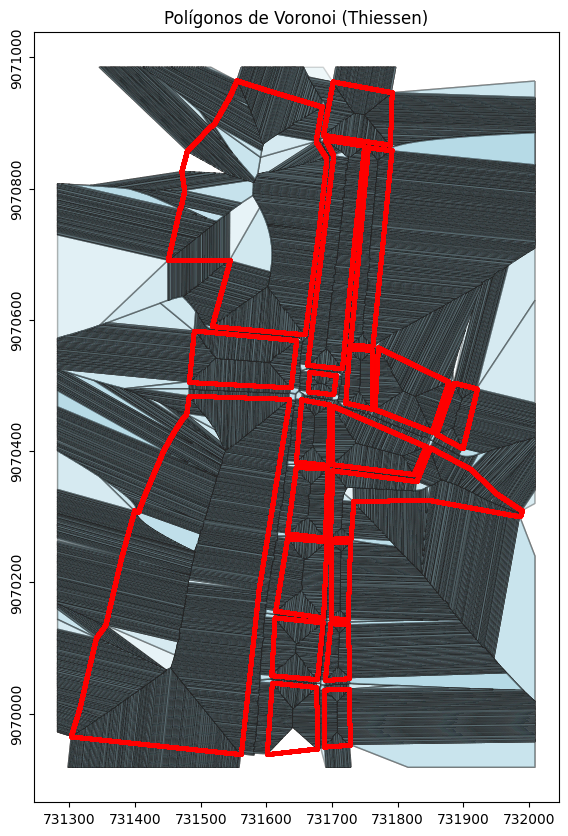

In [9]:
# GRAFICAR
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 10))

# Graficar los polígonos de Voronoi recortados
voronoi_clipped.plot(ax=plt.gca(), color='lightblue', edgecolor='#262626', alpha=0.1)

# Opcional: agregar los puntos generados para el diagrama de Voronoi
points_gdf.plot(ax=plt.gca(), color='red', markersize=5)

# Formatear las coordenadas en el gráfico
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain')

# Formatear los dógitos de las coordenadas
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '')))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y):,}'.replace(',', '')))

# Rotar las etiquetas del eje Y y centrarlas
for label in ax.get_yticklabels():
    label.set_rotation(90)
    label.set_verticalalignment('center')

# Título y etiquetas
plt.title("Polígonos de Voronoi (Thiessen)")
plt.xlabel("")
plt.ylabel("")

# Mostrar la gráfica
plt.show()

In [10]:
# Realizar el spatial join para pasar el identificador a los polígonos de Voronoi recortados
voronoi_with_id_clipped = gpd.sjoin(voronoi_clipped, gdf[['id_mz', 'geometry']], how='left', predicate='intersects')

# Verifica si el identificador ha sido correctamente asignado
print(voronoi_with_id_clipped.head())

                                                geometry  index_right  id_mz
12600  POLYGON ((731559.330 9069940.589, 731560.571 9...            0      0
12604  POLYGON ((731559.330 9069940.589, 731560.571 9...            0      0
12605  POLYGON ((731559.330 9069940.589, 731560.571 9...            0      0
12606  POLYGON ((731559.330 9069940.589, 731560.571 9...            0      0
12607  POLYGON ((731559.330 9069940.589, 731560.571 9...            0      0


In [11]:
# Disolver los polígonos de Voronoi utilizando el identificador único
dissolved_voronoi_clipped = voronoi_with_id_clipped.dissolve(by='id_mz')

# Convertir los polígonos disueltos a polilíneas
polylines_from_voronoi_clipped = dissolved_voronoi_clipped.copy()
polylines_from_voronoi_clipped['geometry'] = polylines_from_voronoi_clipped.boundary

# Verifica las primeras filas del GeoDataFrame final
print(polylines_from_voronoi_clipped.head())

                                                geometry  index_right
id_mz                                                                
0      LINESTRING (731299.188 9069918.251, 731297.869...            0
1      LINESTRING (731599.174 9070156.149, 731599.234...            1
2      LINESTRING (731616.851 9070275.137, 731617.027...            2
3      LINESTRING (731591.069 9070061.427, 731591.135...            3
4      LINESTRING (731581.803 9069948.421, 731581.945...            4


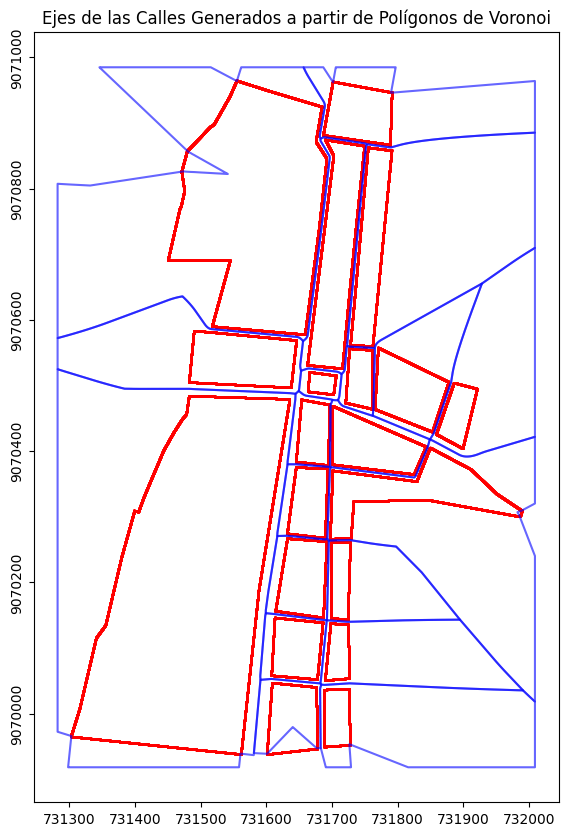

In [12]:
# GRAFICAR
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 10))

# Graficar las polilíneas generadas a partir de los polígonos de Voronoi
polylines_from_voronoi_clipped.plot(ax=plt.gca(), color='blue', edgecolor='black', alpha=0.6)

# Agregar los puntos generados para el diagrama de Voronoi
points_gdf.plot(ax=plt.gca(), color='red', markersize=0.5)

# Formatear las coordenadas en el gráfico
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain')

# Asegurarse de que las coordenadas no se muestren en notación científica
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '')))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y):,}'.replace(',', '')))

# Rotar las etiquetas del eje Y y centrarlas
for label in ax.get_yticklabels():
    label.set_rotation(90)
    label.set_verticalalignment('center')

# Título y etiquetas
plt.title("Ejes de las Calles Generados a partir de Polígonos de Voronoi")
plt.xlabel("")
plt.ylabel("")

# Mostrar la gráfica
plt.show()

In [ ]:
# Guardar
# Polígonos de Voronoi en un shapefile
voronoi_clipped.to_file('../OUT/SHP/Voronoi_Polygons.shp')

# Ejes de las calles en un shapefile
polylines_from_voronoi_clipped.to_file('../OUT/SHP/Eje_Calles.shp')